In [24]:
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import huffman
import math
import faiss
import sys
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')


# CIFAR-10 Experiments: Size reduction through Huffman coding

In [25]:
def plot_pdf_distribution(pdf):
    print(len(pdf))
    plt.rcParams['figure.figsize'] = [4,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    # plt.ticklabel_format(axis='x', style="sci", scilimits=(0,0), useOffset=False)
    # plt.hist(imagenet_pdf2048, bins=25, alpha=0.75, rwidth=0.75)
    # plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of centroids in a bin is hit', xscale='log', autoscale_on=True);
    plt.ticklabel_format(style='plain')
    plt.hist(pdf, bins=25, alpha=0.75, rwidth=0.75) #, log=True)
    plt.gca().set(ylabel='# of centroids in that bin', xlabel='# of times centroids in a bin is hit');

In [26]:
def plot_data_savings(pdf,n_clusters):
    # create the dictionary
    freq_dict = []
    for i in range(n_clusters):
        freq_dict.append((i, pdf[i]))
    code_book = huffman.codebook(freq_dict)   

    code_book_dist = np.zeros((n_clusters,),dtype=np.int)
    for j in range(n_clusters):
        code_book_dist[j]=len(code_book[j])

    plt.rcParams['figure.figsize'] = [3,3]
    plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
    plt.rcParams.update({'font.size': 10})
    plt.ticklabel_format(style='plain')
    plt.hist(code_book_dist, bins=6, alpha=0.75, rwidth=0.75)
    plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    

    base_bits = (math.log10(n_clusters) / math.log10(2))
    print(base_bits)

    # with no encoding, 11 bits needed to encode 2048 symbols
    total_non_encoded = 0
    for i in range(n_clusters):
        total_non_encoded += pdf[i]*base_bits

    total_encoded = 0
    for i in range(n_clusters):
        total_encoded += pdf[i]*code_book_dist[i]
    return 100*(1 - total_encoded/total_non_encoded)

In [27]:
# Basic definitions for CIFAR-10 inference
batch_size = 1
#  From my training code
random_seed = 1 

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Change the dataset folder to the proper location in a new system
testset_cifar = torchvision.datasets.CIFAR10(root='../../dataset', train=False, download=True, transform=transform_test)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size, shuffle=False)
testloader_std_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [28]:
from modeldefs import *

# Base model for Cifar-10 (data [0,1]) 
pretrained_base_clampled_gradinit = './cifar10_resnet_gradinit_sc_232.pt'
model_base_clamped_gradinit = resnet20()
model_base_clamped_gradinit.load_state_dict(torch.load(pretrained_base_clampled_gradinit))
model_base_clamped_gradinit.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [29]:
# Define a custom function that will clamp the images between 0 & 1 , without being too harsh as torch.clamp 
def softclamp01(image_tensor):
    image_tensor_shape = image_tensor.shape
    image_tensor = image_tensor.view(image_tensor.size(0), -1)
    image_tensor -= image_tensor.min(1, keepdim=True)[0]
    image_tensor /= image_tensor.max(1, keepdim=True)[0]
    image_tensor = image_tensor.view(image_tensor_shape)
    return image_tensor

In [30]:
# Lets check the kind of prediction the model is doing - the standard non symbolic infrence
def cifar_test_base_acc(model):
    base_clampled_gradinit_clean = 0
    total = 0
    # Clean base gradinit inference   
    for images, labels in testloader_std_cifar:
        with torch.no_grad():
            X = softclamp01(images) 
            y = labels
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    base_clampled_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(base_clampled_gradinit_clean / total) 

In [10]:
print(" ******++++++++++++++============= Clean base gradinit (scaled data [0,1]) model inference ================+++++++++++******")
acc = cifar_test_base_acc(model_base_clamped_gradinit)
print("Base Non symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Clean base gradinit (soft clamp [0,1]) model inference ================+++++++++++******
Base Non symbolic Grad init (clamped) model Accuracy:91.57


In [31]:
# Lets check the kind of prediction the model is doing - the symbolic infrence
def cifar_test_sym_acc(model, n_clusters, index, centroid_lut, pdf , patch_size, stride, channel_count):
    sym_clampled_gradinit_clean = 0
    total = 0
    # Sym base gradinit inference   
    for images, labels in testloader_cifar:
        with torch.no_grad():
            X = softclamp01(images) 
            y = labels
            Xsym_, pdf = fm_to_symbolic_fm_instr(X.squeeze(), n_clusters, index, centroid_lut, pdf , patch_size, stride, channel_count)
            Xsym = torch.from_numpy(Xsym_)
            Xsym = Xsym.unsqueeze(0)
            output = model.forward(Xsym.float())
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    sym_clampled_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(sym_clampled_gradinit_clean / total), pdf

In [32]:
import faiss
from  patchutils_img_instr import  fm_to_symbolic_fm_instr
patch_size = (2, 2)
channel_count = 3
stride = 0

In [20]:
index = faiss.read_index("./kmeans_img_k2_s0_c2048_v1_softclamp.index")
n_clusters=2048
pdf_2048 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 2048) ================+++++++++++******")
acc, pdf_2048 = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut, pdf_2048 , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:89.42999999999999


In [20]:
index = faiss.read_index("./kmeans_img_k2_s0_c1024_v1_softclamp.index")
n_clusters=1024
pdf_1024 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 1024) ================+++++++++++******")
acc, pdf_1024 = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut, pdf_1024 , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 1024) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:87.62


In [33]:
index = faiss.read_index("./kmeans_img_k2_s0_c512_v1_softclamp.index")
n_clusters=512
pdf_512 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 512) ================+++++++++++******")
acc, pdf_512 = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut, pdf_512 , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 512) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:85.53


In [23]:
index = faiss.read_index("./kmeans_img_k2_s0_c256_v1_softclamp.index")
n_clusters=256
pdf_256 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 256) ================+++++++++++******")
acc, pdf_256 = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut, pdf_256 , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 256) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:80.82000000000001


Non encoded: 84480000
Encoded: 57614022
8.8671875
Savings in storage for CIFAR-10 testset in losless encoding for 256 clusters: 31.80%


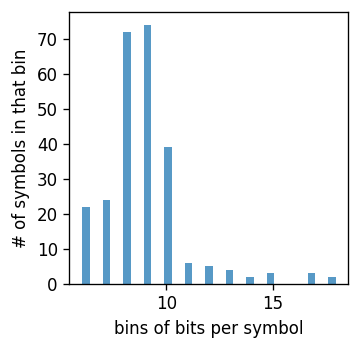

In [34]:
# create the dictionary
freq_dict_256 = []
for i in range(256):
    freq_dict_256.append((i, pdf_256[i]))
codebook256 = huffman.codebook(freq_dict_256)   

codebook_dist256 = np.zeros((256,),dtype=np.int)
for j in range(256):
    codebook_dist256[j]=len(codebook256[j])

plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 10})
#plt.ticklabel_format(style='plain')
plt.hist(codebook_dist256, bins=25, alpha=0.75, rwidth=0.75)
plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    
total_non_encoded = 0
for i in range(256):
    total_non_encoded += pdf_256[i]*11

total_encoded = 0
for i in range(256):
    total_encoded += pdf_256[i]*codebook_dist256[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(codebook_dist256))
print("Savings in storage for CIFAR-10 testset in losless encoding for 256 clusters: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded)))    

In [36]:
index = faiss.read_index("./kmeans_img_k2_s0_c128_v1_softclamp.index")
n_clusters=128
pdf_128 = np.zeros((n_clusters,), dtype=int)
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 128) ================+++++++++++******")
acc, pdf_128 = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut, pdf_128 , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 128) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:72.36


Non encoded: 84480000
Encoded: 49689695
7.9765625
Savings in storage for CIFAR-10 testset in losless encoding for 128 clusters: 41.18%


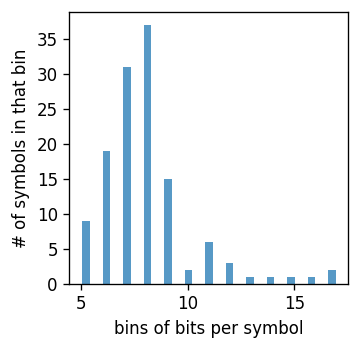

In [37]:
# create the dictionary
freq_dict_128 = []
for i in range(128):
    freq_dict_128.append((i, pdf_128[i]))
codebook128 = huffman.codebook(freq_dict_128)   

codebook_dist128 = np.zeros((128,),dtype=np.int)
for j in range(128):
    codebook_dist128[j]=len(codebook128[j])

plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 10})
#plt.ticklabel_format(style='plain')
plt.hist(codebook_dist128, bins=25, alpha=0.75, rwidth=0.75)
plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    
total_non_encoded = 0
for i in range(128):
    total_non_encoded += pdf_128[i]*11

total_encoded = 0
for i in range(128):
    total_encoded += pdf_128[i]*codebook_dist128[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(codebook_dist128))
print("Savings in storage for CIFAR-10 testset in losless encoding for 128 clusters: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded)))    

Non encoded: 84480000
Encoded: 73051746
10.728515625
Savings in storage for CIFAR-10 testset: 13.53%


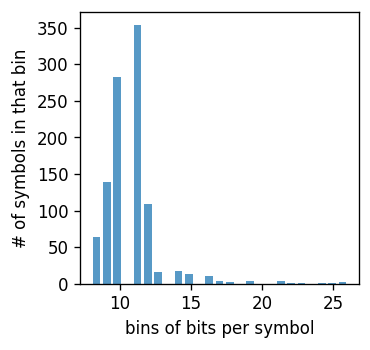

In [21]:
# create the dictionary
freq_dict_1024 = []
for i in range(1024):
    freq_dict_1024.append((i, pdf_1024[i]))
codebook1024 = huffman.codebook(freq_dict_1024)   

codebook_dist1024 = np.zeros((1024,),dtype=np.int)
for j in range(1024):
    codebook_dist1024[j]=len(codebook1024[j])

plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 10})
#plt.ticklabel_format(style='plain')
plt.hist(codebook_dist1024, bins=25, alpha=0.75, rwidth=0.75)
plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    
total_non_encoded = 0
for i in range(1024):
    total_non_encoded += pdf_1024[i]*11

total_encoded = 0
for i in range(1024):
    total_encoded += pdf_1024[i]*codebook_dist1024[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(codebook_dist1024))
print("Savings in storage for CIFAR-10 testset: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded)))    

Non encoded: 84480000
Encoded: 80895988
11.7587890625
Savings in storage for CIFAR-10 testset in losless encoding for 2048 clusters: 4.24%


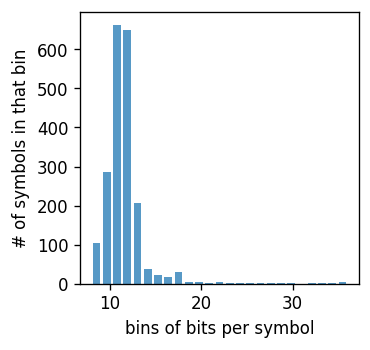

In [29]:
# create the dictionary
freq_dict_2048 = []
for i in range(2048):
    freq_dict_2048.append((i, pdf_2048[i]))
codebook2048 = huffman.codebook(freq_dict_2048)   

codebook_dist2048 = np.zeros((2048,),dtype=np.int)
for j in range(2048):
    codebook_dist2048[j]=len(codebook2048[j])

plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 10})
#plt.ticklabel_format(style='plain')
plt.hist(codebook_dist2048, bins=25, alpha=0.75, rwidth=0.75)
plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    
total_non_encoded = 0
for i in range(2048):
    total_non_encoded += pdf_2048[i]*11

total_encoded = 0
for i in range(2048):
    total_encoded += pdf_2048[i]*codebook_dist2048[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(codebook_dist2048))
print("Savings in storage for CIFAR-10 testset in losless encoding for 2048 clusters: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded)))    

Non encoded: 84480000
Encoded: 65327123
9.826171875
Savings in storage for CIFAR-10 testset in losless encoding for 512 clusters: 22.67%


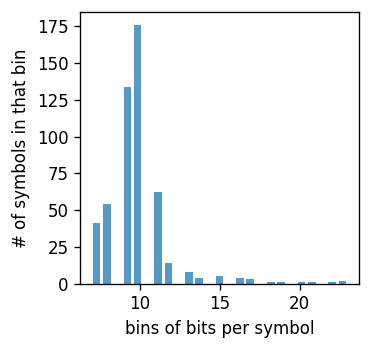

In [28]:
# create the dictionary
freq_dict_512 = []
for i in range(512):
    freq_dict_512.append((i, pdf_512[i]))
codebook512 = huffman.codebook(freq_dict_512)   

codebook_dist512 = np.zeros((512,),dtype=np.int)
for j in range(512):
    codebook_dist512[j]=len(codebook512[j])

plt.rcParams['figure.figsize'] = [3,3]
plt.rcParams['figure.dpi'] = 120 # 200 e.g. is really fine, but slower
plt.rcParams.update({'font.size': 10})
#plt.ticklabel_format(style='plain')
plt.hist(codebook_dist512, bins=25, alpha=0.75, rwidth=0.75)
plt.gca().set(ylabel='# of symbols in that bin', xlabel='bins of bits per symbol');    
total_non_encoded = 0
for i in range(512):
    total_non_encoded += pdf_512[i]*11

total_encoded = 0
for i in range(512):
    total_encoded += pdf_512[i]*codebook_dist512[i]
    
print("Non encoded:", total_non_encoded)    
print("Encoded:", total_encoded)    
print(np.mean(codebook_dist512))
print("Savings in storage for CIFAR-10 testset in losless encoding for 512 clusters: {:.2f}%".format(100*(1 - total_encoded/total_non_encoded)))    